Multi-Digit traning on SVHN dataset
=============

we build a convolutional neural network to train a model to read the number up to 5 digit form the stree-view-house-number (SVHN).


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import numpy as np


In [2]:
pickle_file = '../street_view_house_numbers/SVHN_multi.pickle'


with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [3]:
image_sizeY = train_dataset.shape[1]
image_sizeX = train_dataset.shape[2]
num_labels = 11
num_channels = 1 # grayscale

def reformat(dataset):
  dataset = dataset.reshape(
    (-1, image_sizeY, image_sizeX, num_channels)).astype(np.float32)
  return dataset
train_dataset  = reformat(train_dataset)
valid_dataset  = reformat(valid_dataset[:10000])
test_dataset = reformat(test_dataset[:10000])
valid_labels = valid_labels[:10000]
test_labels = test_labels[:10000]
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (10000, 32, 32, 1) (10000, 6)


In [4]:
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [11]:
batch_size = 128
patch_size1 = 5
patch_size2 = 3
patch_size3 = 1
depth = 16
num_hidden = 128
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_sizeY, image_sizeX, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #keep_prob = tf.placeholder("float")

  # Variables
  w1 = tf.Variable(tf.truncated_normal([patch_size1, patch_size1, num_channels, depth], stddev=0.1))
  b1 = tf.Variable(tf.zeros([depth]))
  w2 = tf.Variable(tf.truncated_normal([patch_size2, patch_size2, depth * 1, depth * 2], stddev=0.1))
  b2 = tf.Variable(tf.constant(1.0, shape=[depth * 2]))
  w3 = tf.Variable(tf.truncated_normal([patch_size2, patch_size2, depth * 2, depth * 4], stddev=0.1))
  b3 = tf.Variable(tf.constant(1.0, shape=[depth * 4]))
  w4 = tf.Variable(tf.truncated_normal([patch_size1, patch_size1, depth * 4, depth * 8], stddev=0.1))
  b4 = tf.Variable(tf.constant(1.0, shape=[depth * 8]))
  w5 = tf.Variable(tf.truncated_normal([patch_size1, patch_size1, depth * 8, depth * 8], stddev=0.1))
  b5 = tf.Variable(tf.constant(1.0, shape=[depth * 8]))
  
  #full-connected layers - 2 layers - 
  #w6 = tf.Variable(tf.truncated_normal([5 * depth * 16, num_hidden], stddev=0.1))
  w6 = tf.Variable(tf.truncated_normal([4 * 4 * depth * 8, num_hidden], stddev=0.1))
  b6 = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  #w7 = tf.Variable(tf.truncated_normal([num_hidden * 2, num_hidden], stddev=0.1))
  #b7 = tf.Variable(tf.constant(1.0, shape=[num_hidden]))


  wC1 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC2 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC3 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC4 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC5 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC5 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC6 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC6 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, keepProb):
    conv = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b1)
    maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(maxOut, w2, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b2)
    maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(maxOut, w3, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b3)
    #maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(hidden, w4, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b4)
    #maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(hidden, w5, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b5)
    maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')  
    
    #full-connected layers - 2 layers -     
    shape = maxOut.get_shape().as_list()
    reshape = tf.reshape(maxOut, [shape[0], shape[1] * shape[2] * shape[3]])
    fc2 = tf.nn.relu(tf.matmul(reshape, w6) + b6)
    #fc2 = tf.nn.relu(tf.matmul(fc1, w7) + b7)
    logitsC1 = tf.matmul(tf.nn.dropout(fc2, keepProb), wC1) + bC1
    logitsC2 = tf.matmul(tf.nn.dropout(fc2, keepProb), wC2) + bC2
    logitsC3 = tf.matmul(tf.nn.dropout(fc2, keepProb), wC3) + bC3
    logitsC4 = tf.matmul(tf.nn.dropout(fc2, keepProb), wC4) + bC4
    logitsC5 = tf.matmul(tf.nn.dropout(fc2, keepProb), wC5) + bC5
    logitsC6 = tf.matmul(tf.nn.dropout(fc2, keepProb), wC6) + bC6
    logits = tf.pack([logitsC1, logitsC2, logitsC3, logitsC4, logitsC5, logitsC6])
    return logits
  
  # Training computation.
  logits = model(tf_train_dataset, 0.8)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:,0])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:,1])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:,2])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:,3])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:,4])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[5], tf_train_labels[:,5]))
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(0.05, global_step, 5000, 0.97)
  learning_rate = tf.train.exponential_decay(0.001, global_step, 10000, 0.9)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
  test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))
  saver = tf.train.Saver()

In [12]:
num_steps = 10000
newAccval = 0.
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,:]))
            oldAccval = newAccval
            newAccval = accuracy(valid_prediction.eval(), valid_labels[:,:])
            print('Validation accuracy: %.1f%%' % newAccval)
            if newAccval-oldAccval <= 0.0 :
                break
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,:]))
    # Save the variables to disk.
    save_path = saver.save(session, "multiDigitSVHN.ckpt")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 542.083313
Minibatch accuracy: 4.9%
Validation accuracy: 25.1%
Minibatch loss at step 500: 5.171356
Minibatch accuracy: 70.4%
Validation accuracy: 70.8%
Minibatch loss at step 1000: 3.425372
Minibatch accuracy: 81.6%
Validation accuracy: 80.1%
Minibatch loss at step 1500: 2.791013
Minibatch accuracy: 84.6%
Validation accuracy: 84.5%
Minibatch loss at step 2000: 1.927348
Minibatch accuracy: 90.6%
Validation accuracy: 87.9%
Minibatch loss at step 2500: 1.482038
Minibatch accuracy: 92.8%
Validation accuracy: 89.5%
Minibatch loss at step 3000: 1.232881
Minibatch accuracy: 93.5%
Validation accuracy: 90.7%
Minibatch loss at step 3500: 1.629136
Minibatch accuracy: 91.8%
Validation accuracy: 91.3%
Minibatch loss at step 4000: 1.353219
Minibatch accuracy: 93.2%
Validation accuracy: 91.3%
Minibatch loss at step 4500: 1.368369
Minibatch accuracy: 93.0%
Validation accuracy: 92.3%
Minibatch loss at step 5000: 1.008749
Minibatch accuracy: 95.1%
Validation accura

In [14]:
############################################################
#Now we need to test our trained model with a dataset 
#
############################################################

batch_size = 128
patch_size1 = 5
patch_size2 = 3
patch_size3 = 1
depth = 16
num_hidden = 128
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_sizeY, image_sizeX, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #keep_prob = tf.placeholder("float")

  # Variables
  w1 = tf.Variable(tf.truncated_normal([patch_size1, patch_size1, num_channels, depth], stddev=0.1))
  b1 = tf.Variable(tf.zeros([depth]))
  w2 = tf.Variable(tf.truncated_normal([patch_size2, patch_size2, depth * 1, depth * 2], stddev=0.1))
  b2 = tf.Variable(tf.constant(1.0, shape=[depth * 2]))
  w3 = tf.Variable(tf.truncated_normal([patch_size2, patch_size2, depth * 2, depth * 4], stddev=0.1))
  b3 = tf.Variable(tf.constant(1.0, shape=[depth * 4]))
  w4 = tf.Variable(tf.truncated_normal([patch_size1, patch_size1, depth * 4, depth * 8], stddev=0.1))
  b4 = tf.Variable(tf.constant(1.0, shape=[depth * 8]))
  w5 = tf.Variable(tf.truncated_normal([patch_size1, patch_size1, depth * 8, depth * 8], stddev=0.1))
  b5 = tf.Variable(tf.constant(1.0, shape=[depth * 8]))
  
  #full-connected layers - 2 layers - 
  #w6 = tf.Variable(tf.truncated_normal([5 * depth * 16, num_hidden], stddev=0.1))
  w6 = tf.Variable(tf.truncated_normal([4 * 4 * depth * 8, num_hidden], stddev=0.1))
  b6 = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  #w7 = tf.Variable(tf.truncated_normal([num_hidden * 2, num_hidden], stddev=0.1))
  #b7 = tf.Variable(tf.constant(1.0, shape=[num_hidden]))


  wC1 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC2 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC3 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC4 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC5 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC5 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  wC6 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  bC6 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b1)
    maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(maxOut, w2, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b2)
    maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(maxOut, w3, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b3)
    #maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(hidden, w4, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b4)
    #maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    conv = tf.nn.conv2d(hidden, w5, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + b5)
    maxOut = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')  
    
    #full-connected layers - 2 layers -     
    shape = maxOut.get_shape().as_list()
    reshape = tf.reshape(maxOut, [shape[0], shape[1] * shape[2] * shape[3]])
    fc2 = tf.nn.relu(tf.matmul(reshape, w6) + b6)
    #fc2 = tf.nn.relu(tf.matmul(fc1, w7) + b7)
    logitsC1 = tf.matmul(tf.nn.dropout(fc2, 1.0), wC1) + bC1
    logitsC2 = tf.matmul(tf.nn.dropout(fc2, 1.0), wC2) + bC2
    logitsC3 = tf.matmul(tf.nn.dropout(fc2, 1.0), wC3) + bC3
    logitsC4 = tf.matmul(tf.nn.dropout(fc2, 1.0), wC4) + bC4
    logitsC5 = tf.matmul(tf.nn.dropout(fc2, 1.0), wC5) + bC5
    logitsC6 = tf.matmul(tf.nn.dropout(fc2, 1.0), wC6) + bC6
    logits = tf.pack([logitsC1, logitsC2, logitsC3, logitsC4, logitsC5, logitsC6])
    return logits

  # Training computation.
  logits = model(tf_test_dataset)
  predict = tf.pack([tf.nn.softmax(logits[0]),tf.nn.softmax(logits[1]),tf.nn.softmax(logits[2]),\
                         tf.nn.softmax(logits[3]),tf.nn.softmax(logits[4]),tf.nn.softmax(logits[5])])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver = tf.train.Saver()


with tf.Session(graph=graph) as session:
  saver.restore(session, "multiDigitSVHN.ckpt")
  print("Model restored.")  
  im_samples = 100
  print('Initialized')
  test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset,})
  print(test_prediction)

Model restored.
Initialized
[[ 1  5 10 10 10 10]
 [ 3  2  1  0 10 10]
 [ 1  6 10 10 10 10]
 ..., 
 [ 2  2  1 10 10 10]
 [ 1  2 10 10 10 10]
 [ 3  1  4  3 10 10]]


[ 2  4  8 10 10 10]
[ 2  4  8 10 10 10]


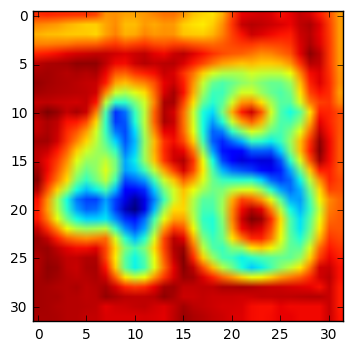

In [15]:
%matplotlib inline
num = 2435
img = np.asarray(test_dataset[num,:,:,0])
plt.figure()
plt.imshow(img)
print(test_labels[num])
print(test_prediction[num])

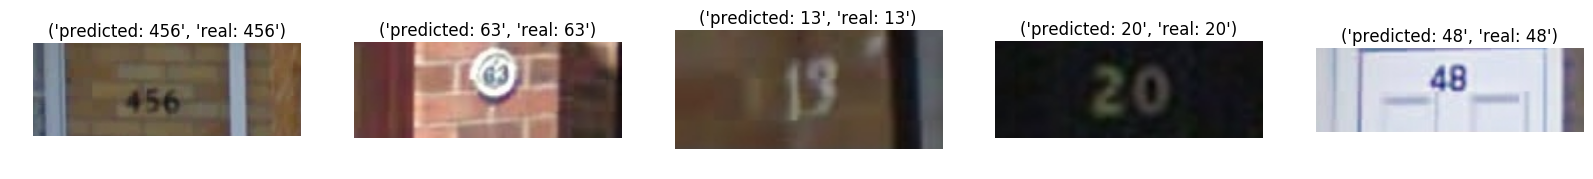

In [17]:
from PIL import Image
import os
import sys
%matplotlib inline

numOfDig = 5
numCol = 5

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=numCol)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=numCol))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('../street_view_house_numbers/test', filename)
    im = Image.open(fullname)
    house_num = ''
    preHouseNum = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    for k in np.arange(test_prediction[j,0]):
        preHouseNum += str(test_prediction[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(('predicted: '+preHouseNum,'real: '+house_num), loc='center')
    ax[i].imshow(im)